# OCR
Comparacion clasificador gaussiano red convolucional y ~~Tesseract OCR~~
Al final no he usado Tesseract OCR porque la ultima version tiene problemas reconociendo numeros
y depues de probar multiples configuraciones no he conseguido encontrar ninguna que de la misma precision
que la red convolucional

In [1]:
# Modules needed and functions
import cv2               as cv
import numpy             as np

import matplotlib.pyplot as plt
%matplotlib inline

Vamos a empezar con MLP con conv, para ello tenemos que cargar una database sobre la cual vamos
a aprender.
En este caso es [mnist](!http://yann.lecun.com/exdb/mnist/) una database con numeros manuscritos


(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


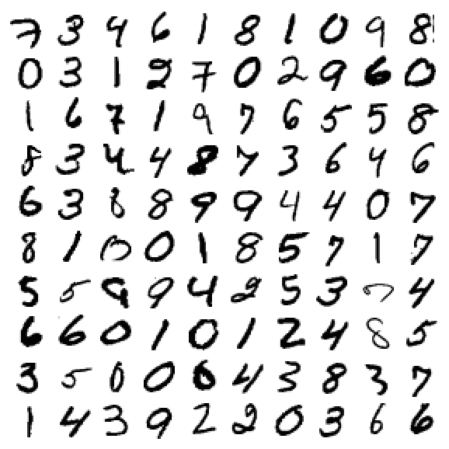

In [2]:

mnist = np.load("../data/mnist.npz")

xl,yl,xt,yt = [mnist[d] for d in ['xl', 'yl', 'xt', 'yt']]

cl = np.argmax(yl,axis=1)
ct = np.argmax(yt,axis=1)

print(xl.shape, yl.shape)
print(xt.shape, yt.shape)

def muestrario(imgs,n=10):
    N = len(imgs)
    c = N // n
    r = N %  n
    L = imgs + [np.zeros_like(imgs[0]) for k in range(n-r)]
    return np.vstack([ np.hstack([ x for x in L[n*k : n*(k+1)]]) for k in range(c if n*c==N else c+1)])
plt.figure(figsize=(8,8))
plt.imshow(-muestrario([x.reshape(28,28) for x in xl[:100]]),'gray');
plt.axis('off');

Creamos la red convolucional

In [3]:
import keras
#import pydot
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#keras.utils.vis_utils.pydot = pydot

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Softmax, Flatten
from keras.utils import plot_model

model = Sequential()
model.add(Conv2D(input_shape=(28,28,1), filters=32, kernel_size=(5,5), strides=1,
                 padding='same', use_bias=True, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), strides=1,
                 padding='same', use_bias=True, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Using TensorFlow backend.


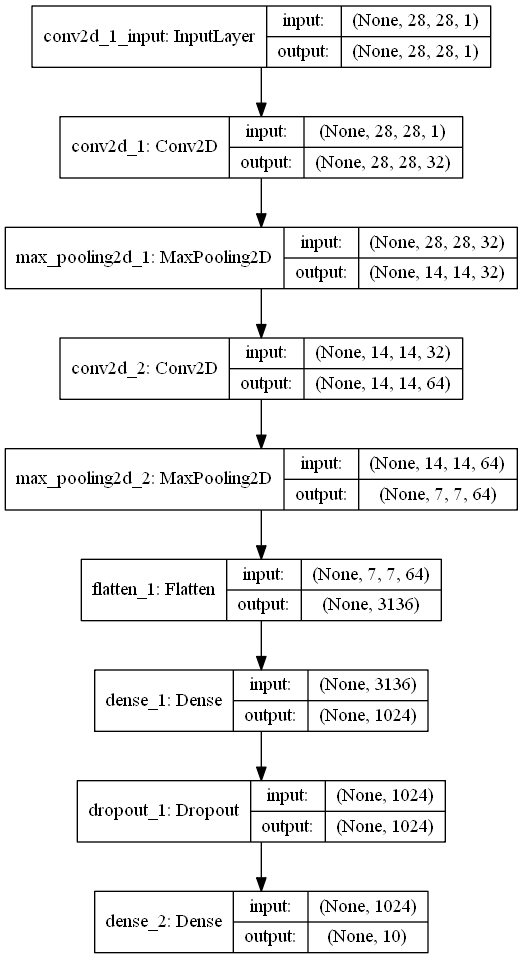

In [4]:
plot_model(model, show_shapes=True)


In [5]:
if False:
    model.fit(xl.reshape(-1,28,28,1), yl, epochs=50, batch_size=500)
    model.save('../data/digits.keras')
else:
    #wget https://robot.inf.um.es/material/va/digits.keras
    model.load_weights('../data/digits.keras')

model.evaluate(xt.reshape(-1,28,28,1),yt, batch_size=500)

10000/10000 [==============================] - 2s 247us/step


[0.0507571060443297, 0.9837999939918518]

Como podemos ver esta red convolucional tiene una precision enorme asique vamos a probarla para nuestros
numeros.

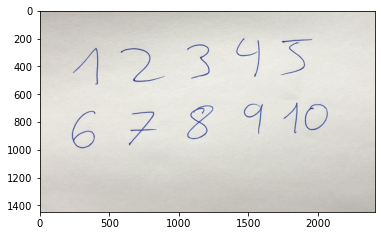

In [6]:
digits = cv.cvtColor(cv.imread('../img/OCR/mydigits.JPEG'),cv.COLOR_BGR2RGB);
plt.imshow(digits);



Luego umbralizamos

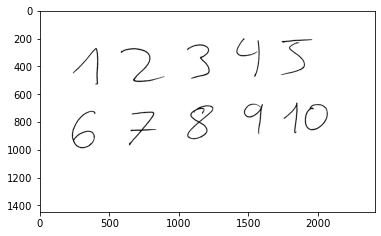

In [7]:
ret, gt = cv.threshold(cv.cvtColor(digits,cv.COLOR_RGB2GRAY),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(gt,'gray');

Y aplicamos la serie de funciones que usa mnist para normalizar y extaer imagenes claras de cada numero.

In [8]:
def center(p):
    r,c = p.shape
    rs = np.outer(range(r),np.ones(c))
    cs = np.outer(np.ones(r),range(c))
    s = np.sum(p)
    my  = np.sum(p*rs) / s
    mx  = np.sum(p*cs) / s
    return mx,my

def boundingBox(c):
    (x1, y1), (x2, y2) = c.min(0), c.max(0)
    return (x1, y1), (x2, y2)

# La figura se escala a un tamaño 20x20
# respetando la proporción de tamaño
# El resultado se mete en una caja 28x28 de
# modo que la media quede en el centro
def adaptsize(x):
    h,w = x.shape
    s = max(h,w)
    h2 = (s-h)//2
    w2 = (s-w)//2
    y = x
    if w2>0:
        z1 = np.zeros([s,w2])
        z2 = np.zeros([s,s-w-w2])
        y  = np.hstack([z1,x,z2])
    if h2>0:
        z1 = np.zeros([h2,s])
        z2 = np.zeros([s-h-h2,s])
        y  = np.vstack([z1,x,z2])
    y = cv.resize(y,(20,20))/255
    mx,my = center(y)
    H = np.array([[1.,0,4-(mx-9.5)],[0,1,4-(my-9.5)]])
    return cv.warpAffine(y,H,(28,28))

Sacamos todos los contornos, los rectángulos que los engloban y adaptamos el tamaño de todas las manchas encontradas.

array([7, 6, 8, 0, 9, 1, 2, 4, 3, 3, 1, 7, 6], dtype=int64)

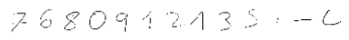

In [10]:
contours,_ = cv.findContours(255-gt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2:]
regions = [ boundingBox(x.reshape(-1,2)) for x in contours ]

# invertimos para seleccionar la tinta negra como objeto, y tener 0:papel blanco, 1: tinta.
raw = [ 255-gt[y1:y2,x1:x2] for (x1,y1),(x2,y2) in regions if x2-x1 > 10 and y2-y1 > 10]
ok = [ adaptsize(x) for x in raw ]

#Este se ve "bien"
#plt.imshow(-ok[3],'gray');
#Pero los ultimos se ven bastante mal
plt.imshow(-np.hstack([x.reshape(28,28) for x in ok]),'gray'); plt.axis('off');
model.predict_classes(np.array(ok).reshape(-1,28,28,1))

Obtenemos una baja precision y observamos que los ultimos números no se ven , para evitarlo dilatanamos el trazo.

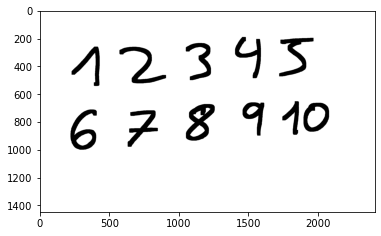

In [12]:
gt_dilatado = cv.erode(gt, None, iterations=10)
plt.imshow(gt_dilatado,'gray');

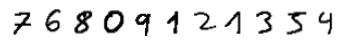

In [13]:
contours,_ = cv.findContours(255-gt_dilatado, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2:]
regions = [ boundingBox(x.reshape(-1,2)) for x in contours ]

# invertimos para seleccionar la tinta negra como objeto, y tener 0:papel blanco, 1: tinta.
raw = [ 255-gt_dilatado[y1:y2,x1:x2] for (x1,y1),(x2,y2) in regions if x2-x1 > 10 and y2-y1 > 10]
ok = [ adaptsize(x) for x in raw ]

#Ahora los numeros se ven correctamente
plt.imshow(-np.hstack([x.reshape(28,28) for x in ok]),'gray'); plt.axis('off');

Veamos como predice mis numero actuales

array([7, 6, 8, 0, 9, 4, 2, 4, 3, 5, 4], dtype=int64)

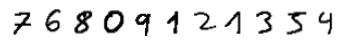

In [14]:
plt.imshow(-np.hstack([x.reshape(28,28) for x in ok]),'gray'); plt.axis('off');
model.predict_classes(np.array(ok).reshape(-1,28,28,1))

Predice todos perfectamente menos los unos que piensa que son cuatros.


In [15]:
def predice_num(path_img=None):
    if path_img is None:
        path_img = "../img/OCR/unos.png"
    digits = cv.cvtColor(cv.imread(path_img),cv.COLOR_BGR2RGB);
    ret, gt = cv.threshold(cv.cvtColor(digits,cv.COLOR_RGB2GRAY),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    # Extraemos contornos y las regiones de cada numero
    contours,_ = cv.findContours(255-gt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2:]
    regions = [ boundingBox(x.reshape(-1,2)) for x in contours ]

    # invertimos para seleccionar la tinta negra como objeto, y tener 0:papel blanco, 1: tinta.
    raw = [ 255-gt[y1:y2,x1:x2] for (x1,y1),(x2,y2) in regions if x2-x1 > 10 and y2-y1 > 10]
    ok = [ adaptsize(x) for x in raw ]

    plt.imshow(-np.hstack([x.reshape(28,28) for x in ok]),'gray'); plt.axis('off');
    prediciones = model.predict_classes(np.array(ok).reshape(-1,28,28,1))
    print(prediciones)

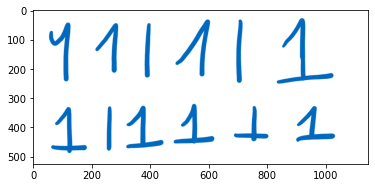

In [16]:
digits = cv.cvtColor(cv.imread('../img/OCR/unos_raros.png'),cv.COLOR_BGR2RGB);
plt.imshow(digits);

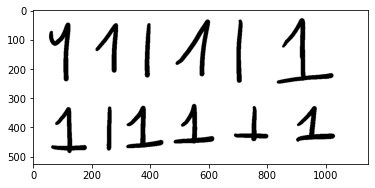

In [17]:
ret, gt = cv.threshold(cv.cvtColor(digits,cv.COLOR_RGB2GRAY),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(gt,'gray');

array([1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

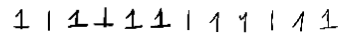

In [18]:
contours,_ = cv.findContours(255-gt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2:]
regions = [ boundingBox(x.reshape(-1,2)) for x in contours ]

# invertimos para seleccionar la tinta negra como objeto, y tener 0:papel blanco, 1: tinta.
raw = [ 255-gt[y1:y2,x1:x2] for (x1,y1),(x2,y2) in regions if x2-x1 > 10 and y2-y1 > 10]
ok = [ adaptsize(x) for x in raw ]

#Este se ve "bien"
plt.imshow(-ok[3],'gray');
#Pero los ultimos se ven bastante mal
plt.imshow(-np.hstack([x.reshape(28,28) for x in ok]),'gray'); plt.axis('off');
model.predict_classes(np.array(ok).reshape(-1,28,28,1))

En este caso predice todos los unos bien menos los que tiene palito. Si cogemos una imagen que solo tiene unos con palito.
Nuestro modelo no sabe que hacer dado que no ha aprendido que los unos pueden tener palito dado que no habian en el conjunto
de aprendizaje.


[1 4 7 7 7 7 4 1 1 4 1 1 1 1]


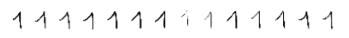

In [19]:
predice_num("../img/OCR/unos.png")

# Clasificador Gausiano
Vamos a probar a usar ahora un clasificador gausiano


In [20]:
from sklearn import random_projection, decomposition, naive_bayes, discriminant_analysis
from sklearn.metrics import confusion_matrix

# una utilidad para calcular la "accuracy" (probabilidad de acierto)
def acc(maq,x,y):
    return 100*(y == maq.predict(x)).sum() / len(y)
# Reducimos las dimensiones 
transformer = decomposition.PCA(n_components=40).fit(xl)
# Y reducimos los datos de entrenamiento y test
xrl = transformer.transform(xl)
xrt = transformer.transform(xt)
#Clasificador gausiano normal
maq = discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True).fit(xrl,cl)
acc(maq,xrt,ct)

96.27

Igual que antes tenemos que dilatar para predecir correctamente.

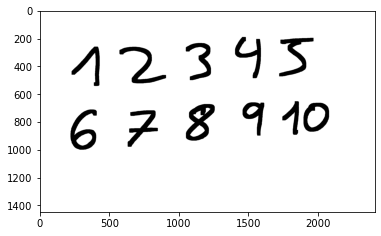

In [21]:
digits = cv.cvtColor(cv.imread('../img/OCR/mydigits.JPEG'),cv.COLOR_BGR2RGB);
ret, gt = cv.threshold(cv.cvtColor(digits,cv.COLOR_RGB2GRAY),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
gt_dilatado = cv.erode(gt, None, iterations=10)
plt.imshow(gt_dilatado,'gray');

array([2, 6, 8, 0, 9, 4, 2, 4, 3, 5, 4], dtype=int64)

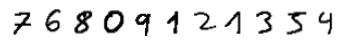

In [22]:
contours,_ = cv.findContours(255-gt_dilatado, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2:]
regions = [ boundingBox(x.reshape(-1,2)) for x in contours ]
# invertimos para seleccionar la tinta negra como objeto, y tener 0:papel blanco, 1: tinta.
raw = [ 255-gt_dilatado[y1:y2,x1:x2] for (x1,y1),(x2,y2) in regions if x2-x1 > 10 and y2-y1 > 10]
ok = [ adaptsize(x) for x in raw ]



#Ahora los numeros se ven correctamente
plt.imshow(-np.hstack([x.reshape(28,28) for x in ok]),'gray'); plt.axis('off');


digits = np.array(ok).reshape(-1,28*28)

plt.imshow(-np.hstack([x.reshape(28,28) for x in ok]),'gray'); plt.axis('off');
maq.predict(transformer.transform(digits))

A diferencia que con convolucion,bayes no predice correctamente el 7.

# Tesseract OCR
Desisto en intentan predecir correctamente usando Tesseract, cambian párametros de versión en versión,
la documentación de los parámetros incomoda de usar; de cualquier manera aqui esta lo que medio conseguido hacer.
Parece ser que si usamos LMT no se puede configurar apenas [nada](!https://github.com/tesseract-ocr/tesseract/issues/751)

De cualquier manera consegui medio configurar esto pero para predecir numeros sigue siendo mucho mejor usar redes neuronales.


In [71]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
digits = cv.cvtColor(cv.imread("../img/OCR/mydigits.JPEG"),cv.COLOR_BGR2RGB);
text=pytesseract.image_to_string(digits,lang='eng') 
print(text)

Ocr dice que es  = 31

5


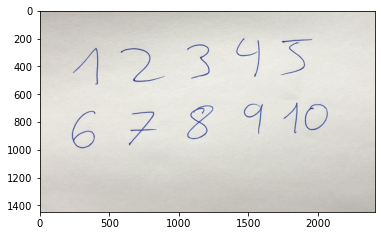

In [72]:
custom_config = r'-c tessedit_char_whitelist=1234567890 --psm 11'
print(f"Ocr dice que es  = {pytesseract.image_to_string(digits, config=custom_config)}") 
plt.imshow(digits,'gray')

Y si intenamos predecir un solo numero nos sale algo asi

Ocr dice que es  = 


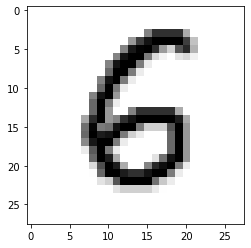

In [73]:
custom_config = r'-c tessedit_char_whitelist=1234567890 --psm 8'
print(f"Ocr dice que es  = {pytesseract.image_to_string(-ok[0], config=custom_config)}") 
plt.imshow(-ok[1],'gray')



 # Video Programa funcionando
 Aqui dejo un video del OCR reconociendo numeros usando una red Convolucional

<video controls src="../img/OCR/ocr_working.mp4" />